In [1]:
import os
import sys

import sys
sys.path.append('../')  # Adding the core library

from maze.models import EfficientUNet
from maze.datasets import FishHeatmapDataset, RandomPoissonNoise

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import kornia.augmentation as K

# Dataset

Create a construct which loads the data based in COCO format, with additional heatmaps stored separately, with same naming as the source image.

In [2]:
# 1. Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. Setup data augmentation and dataset
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

augmentation_transform = nn.Sequential(
    RandomPoissonNoise(p=0.15),
    K.RandomGaussianNoise(mean=0.0, std=0.05, p=0.5),
    K.RandomGaussianBlur(kernel_size=(5, 5), sigma=(0.5, 1.5), p=0.1),
    K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.3),
).to(device)


Using device: cuda


# Preload the data

We preload the data into DDR memory, as its not so big, and it speeds up the training process massively.

In [3]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    background_dir='../data/training/background/',
    background_prob=0.3,
    joint_transform=joint_train,
    augmentation_transform=augmentation_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    background_dir='../data/training/background/',
    background_prob=0.3,
    joint_transform=joint_val,
    augmentation_transform=augmentation_transform,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

Loaded 5493 samples after excluding 0 flagged samples.
Adding 321 background samples from 321 available files.
Loaded 611 samples after excluding 0 flagged samples.
Adding 183 background samples from 321 available files.


# Training

Let's setup our loss, optimizer etc.
1. **Loss**: we do binary cross entropy with logits, where we boost the center weights in the heatmap to bring up the attention to the center and positive values in general, and away from the background that in our case is a lot more present (fish is quite small in almost each window). We also do centroid distance boosting in the loss, as the position of the centroid is of crucial importance to the tracking.
2. **Optimizer**: AdamW 
3. **LR scheduler**: ReduceLROnPlateau 

Later we run the training loop. 

In [4]:

# 2. Initialize the model
model = EfficientUNet()

# Freeze first 3 stages of the encoder (enc1 to enc3)
for param in model.enc1.parameters():
    param.requires_grad = False
for param in model.enc2.parameters():
    param.requires_grad = False
for param in model.enc3.parameters():
    param.requires_grad = False

model = model.to(device)

# 3. Loss setup
def weighted_bce_with_logits(pred, target, limit=0.8, pos_weight=20.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

alpha = 0.005  # Weight for the centroid distance loss

def get_centroid(heatmap):
    if heatmap.sum() < 1e-8:
        return None

    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w

    confidence = heatmap[torch.arange(b), 0, y, x]  # shape: [B]

    return x.float(), y.float(), confidence.float()

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

# 4. Optimizer & scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


In [5]:
# 5. Training Loop Setup
epochs = 100
epoch_save_interval = 5

model_dir = '../data/models/efficientunet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# 6. Training Loop
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)
best_val_loss = float('inf')


for epoch in range(epochs):
    model.train()
    augmentation_transform.train()
    train_loss = 0.0
    train_cdist_loss = 0.0
    cdist_num = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for imgs, heatmaps in train_bar:
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)
        
        mse = weighted_bce_with_logits(preds, heatmaps)
        cdist, distances = centroid_distance_loss(preds, heatmaps)
        loss = mse + alpha * cdist

        if distances > 0:
            train_cdist_loss += cdist.item() * distances
            cdist_num += distances

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)

    if cdist_num > 0:
        train_cdist_loss /= cdist_num

    model.eval()
    augmentation_transform.eval()

    val_loss = 0.0
    val_cdist_loss = 0.0
    cdist_num = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    with torch.no_grad():
        for imgs, heatmaps in val_bar:
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)

            mse = weighted_bce_with_logits(preds, heatmaps)
            cdist, distances = centroid_distance_loss(preds, heatmaps)
            loss = mse + alpha * cdist

            if distances > 0:
                val_cdist_loss += cdist.item() * distances
                cdist_num += distances

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if cdist_num > 0:
        val_cdist_loss /= cdist_num

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train CDist = {train_cdist_loss:.4f} Val Loss = {val_loss:.4f}, Val CDist = {val_cdist_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    # Save model checkpoint every N epochs
    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

# Model Validation

Now let's put model through numerous tests to see how well it performs.

In [7]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [8]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(imgs))

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(imgs)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()
            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]


Average centroid distance: 5.19 px, Average confidence: 0.87
Within 3px: 46.32%
Within 5px: 75.12%
Within 10px: 92.64%


In [9]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    gt_value_center = gt.numpy()[int(yg), int(xg)]
    p_value_center = pred.numpy()[int(yp), int(xp)]

    print(f"GT Value at center: {gt_value_center:.2f}, Pred Value at center: {p_value_center:.2f}")

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()



GT Value at center: 1.00, Pred Value at center: 0.04


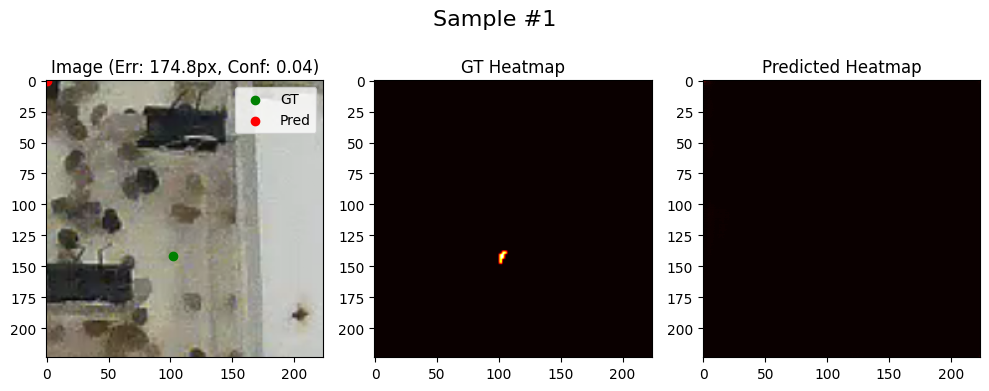

GT Value at center: 1.00, Pred Value at center: 0.02


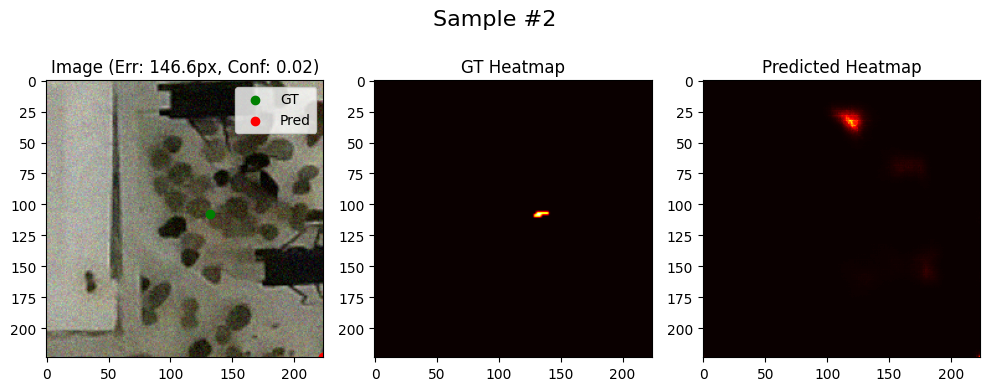

GT Value at center: 0.95, Pred Value at center: 0.35


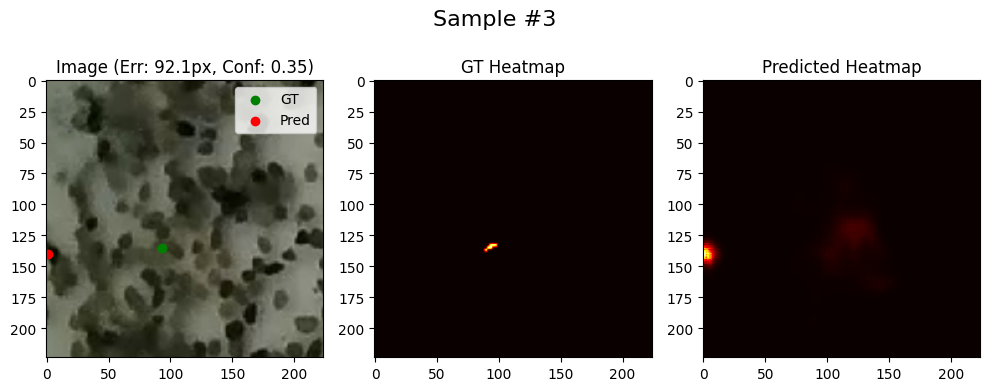

GT Value at center: 0.87, Pred Value at center: 0.85


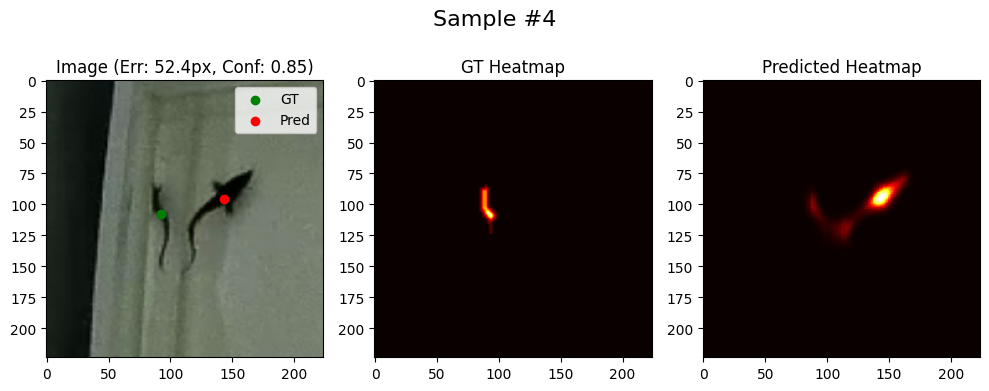

GT Value at center: 1.00, Pred Value at center: 0.90


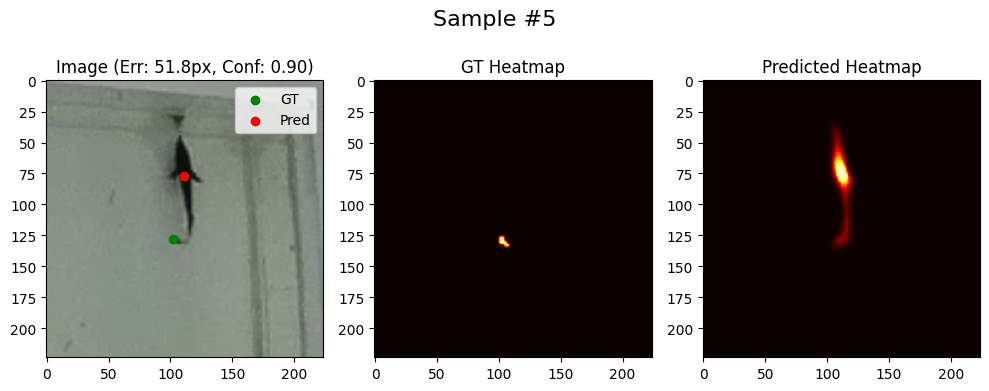

GT Value at center: 0.95, Pred Value at center: 0.02


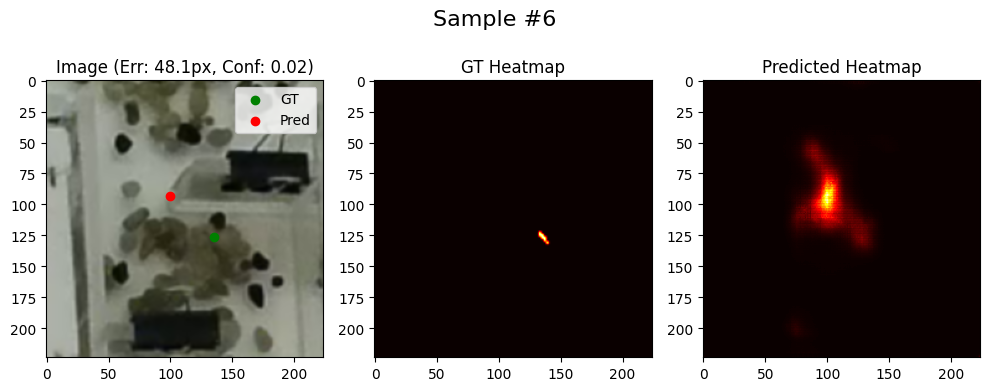

GT Value at center: 0.90, Pred Value at center: 0.84


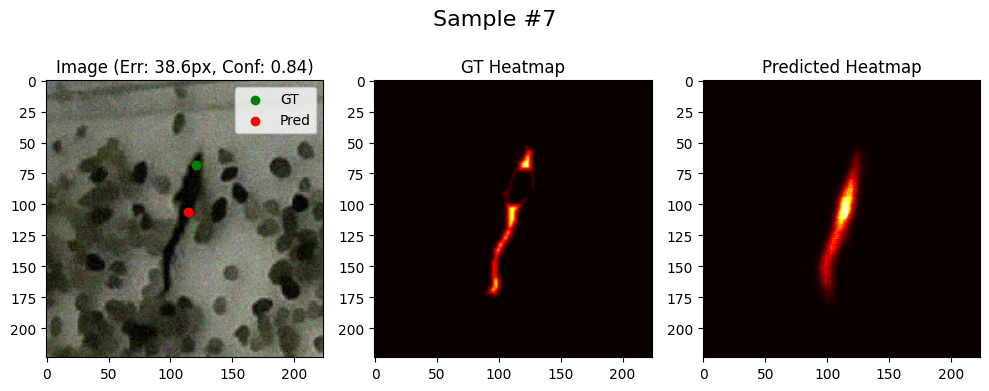

GT Value at center: 0.91, Pred Value at center: 0.86


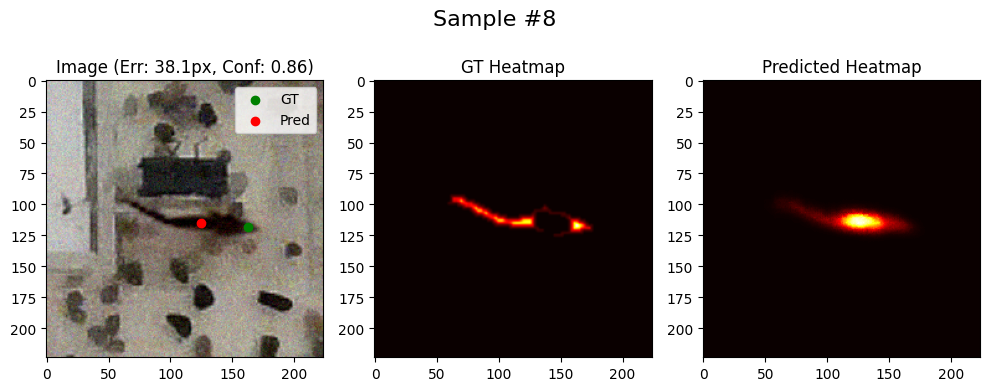

GT Value at center: 0.91, Pred Value at center: 0.79


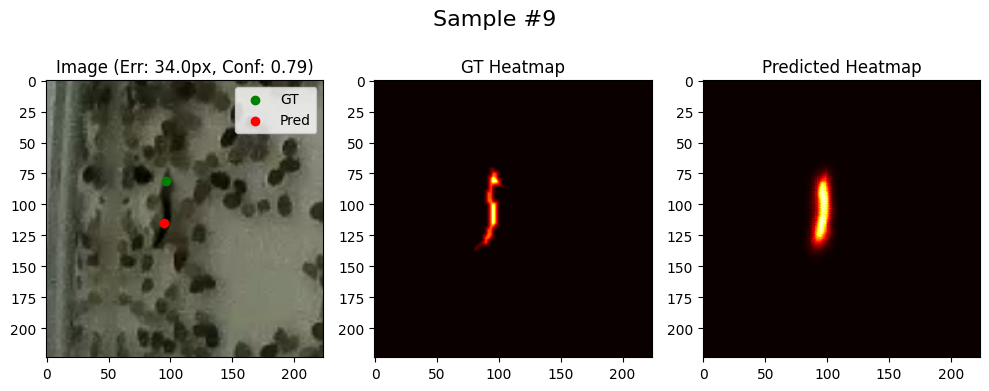

GT Value at center: 0.96, Pred Value at center: 0.85


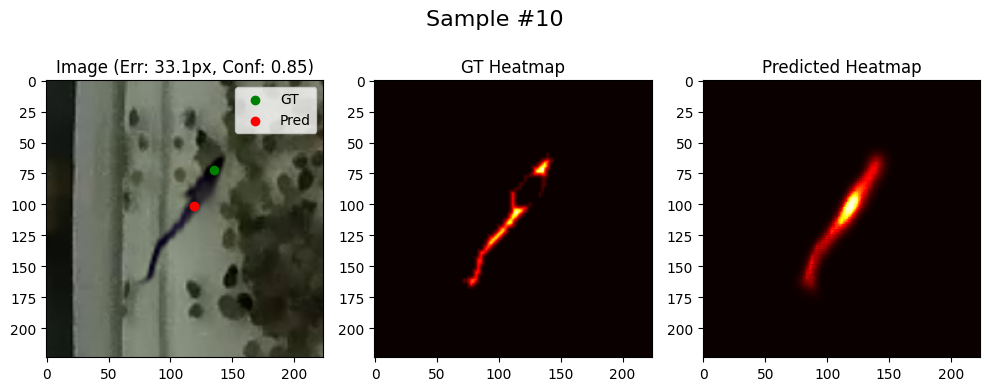

In [10]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

GT Value at center: 0.92, Pred Value at center: 0.89


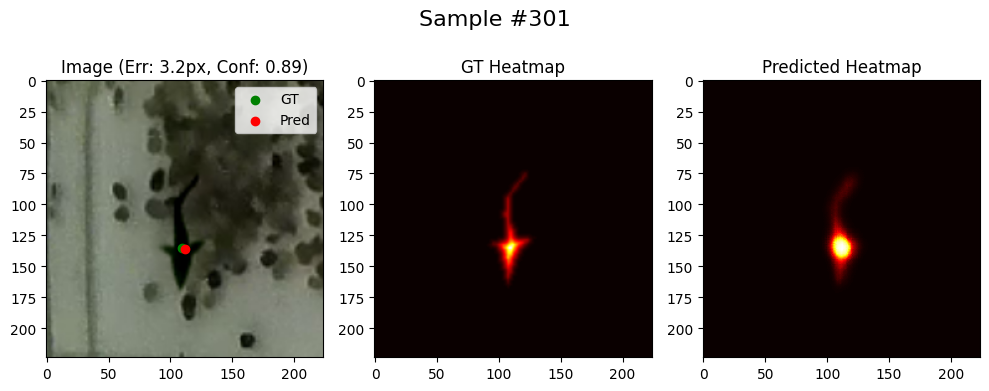

GT Value at center: 0.92, Pred Value at center: 0.90


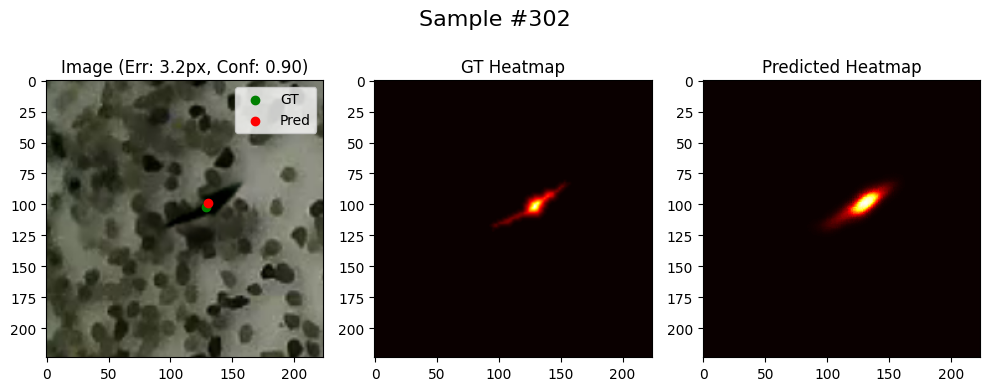

GT Value at center: 0.96, Pred Value at center: 0.88


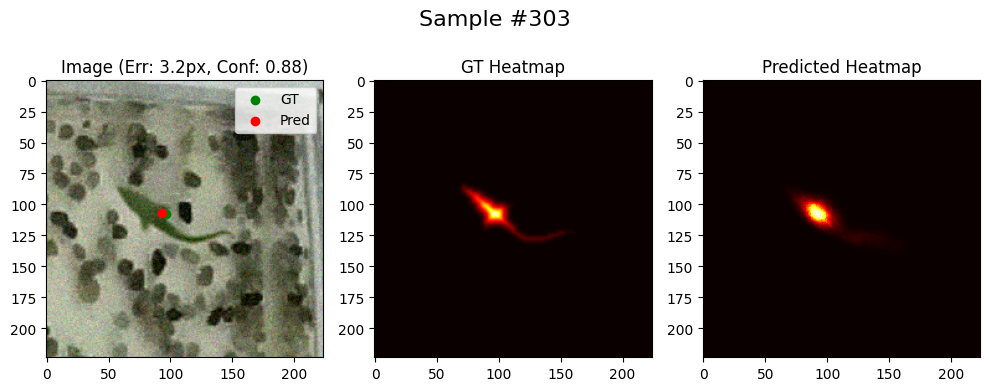

GT Value at center: 0.98, Pred Value at center: 0.88


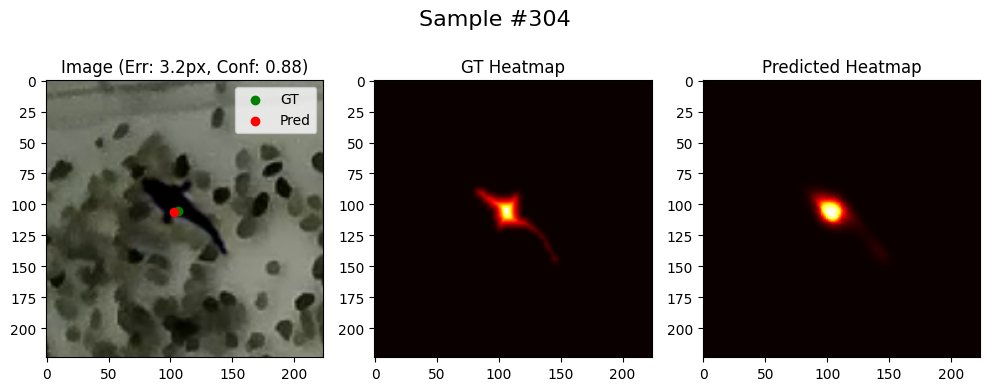

GT Value at center: 0.93, Pred Value at center: 0.85


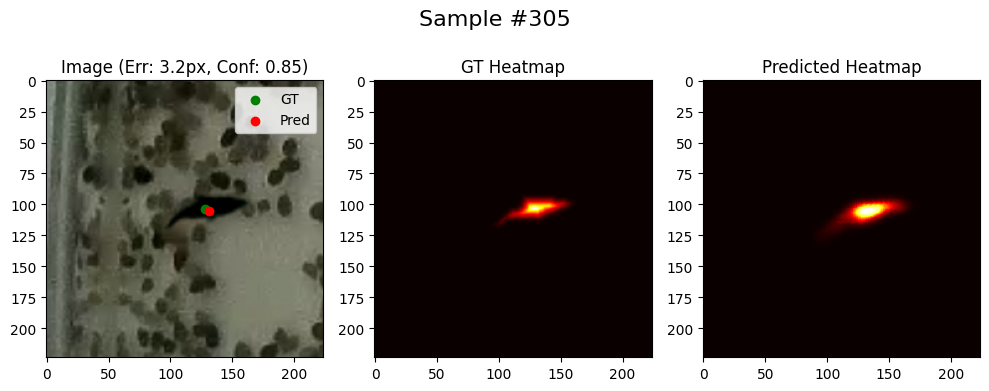

GT Value at center: 0.96, Pred Value at center: 0.87


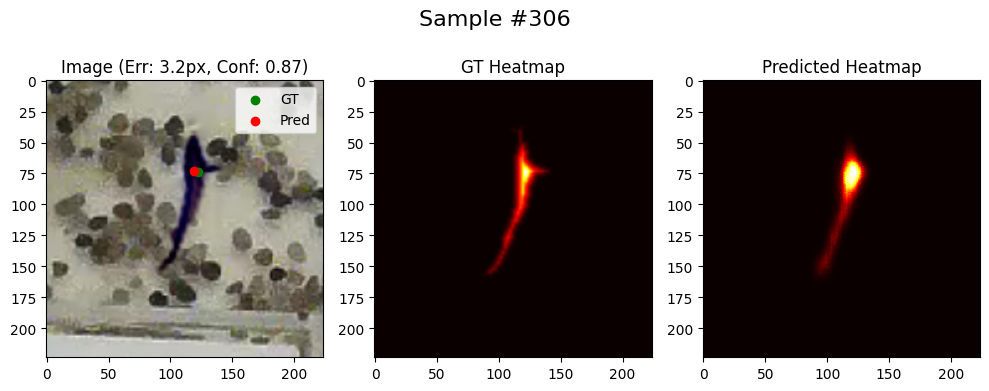

GT Value at center: 0.95, Pred Value at center: 0.86


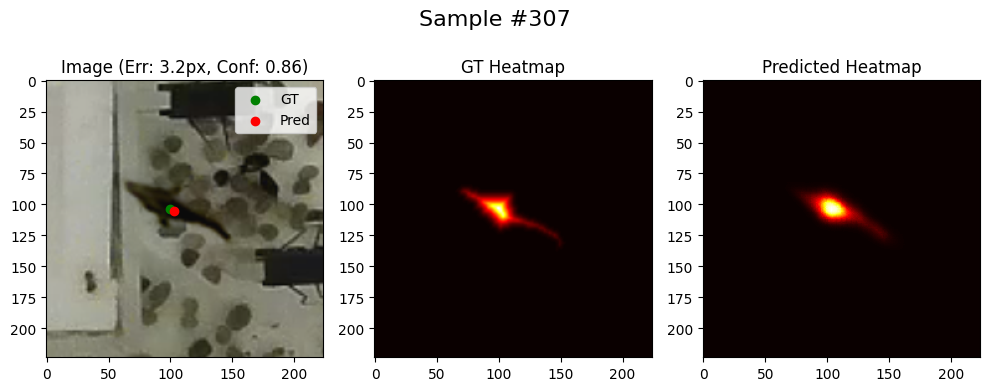

GT Value at center: 0.95, Pred Value at center: 0.93


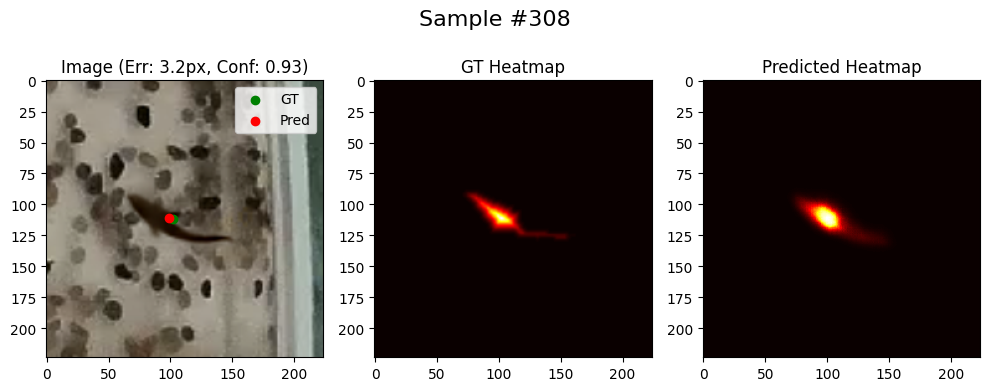

GT Value at center: 0.98, Pred Value at center: 0.88


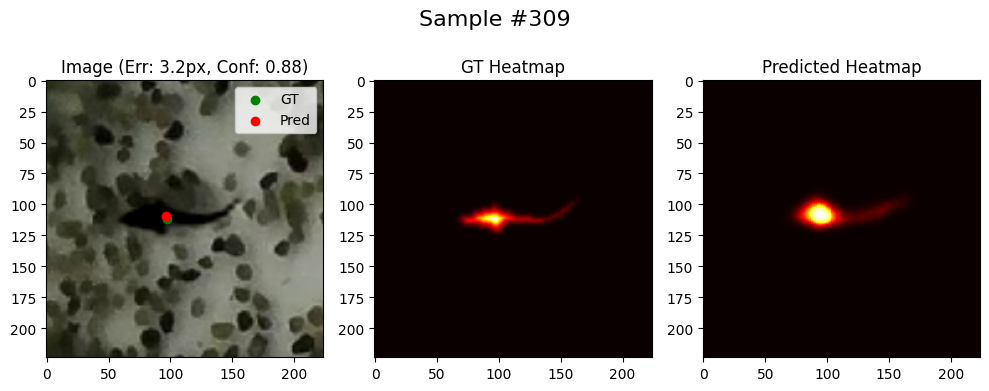

GT Value at center: 0.97, Pred Value at center: 0.83


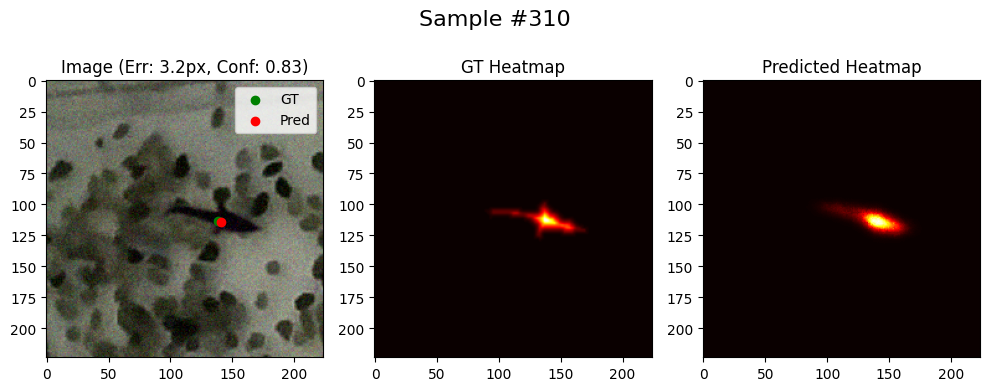

In [11]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

GT Value at center: 0.97, Pred Value at center: 0.88


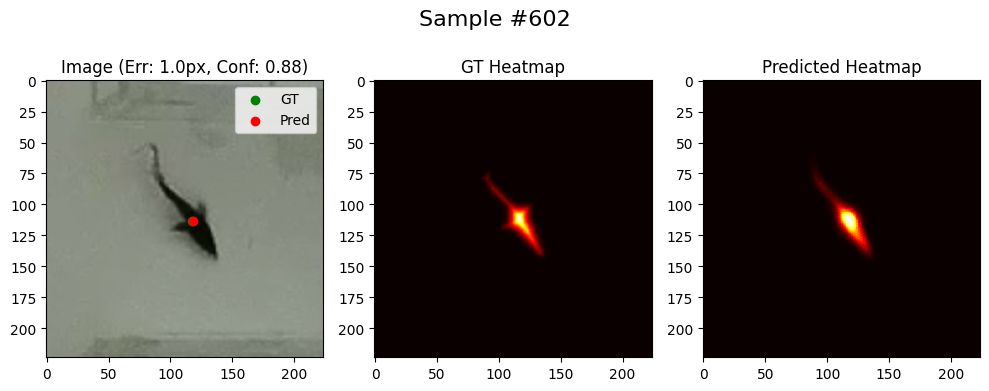

GT Value at center: 0.93, Pred Value at center: 0.87


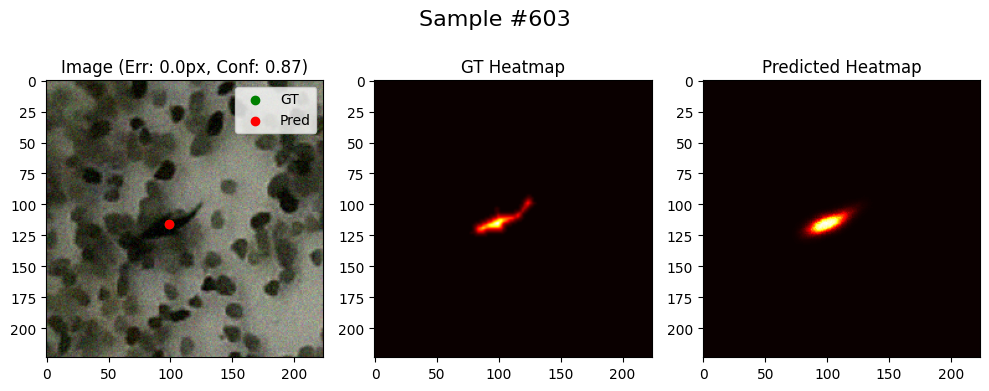

GT Value at center: 0.94, Pred Value at center: 0.90


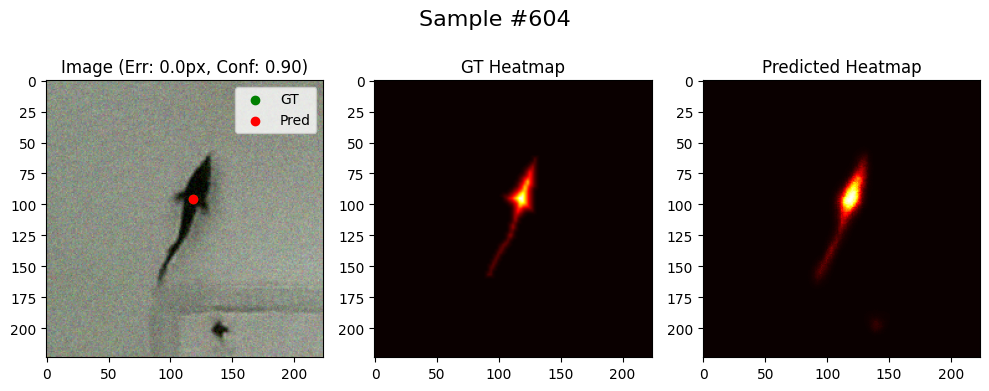

GT Value at center: 0.92, Pred Value at center: 0.88


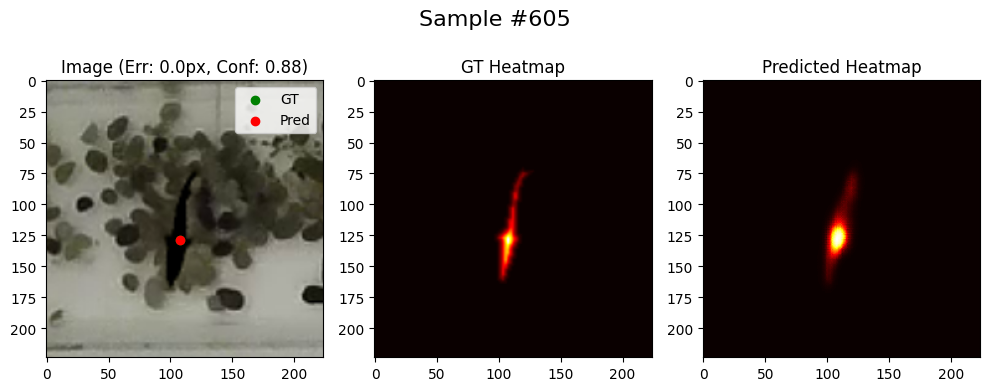

GT Value at center: 0.94, Pred Value at center: 0.90


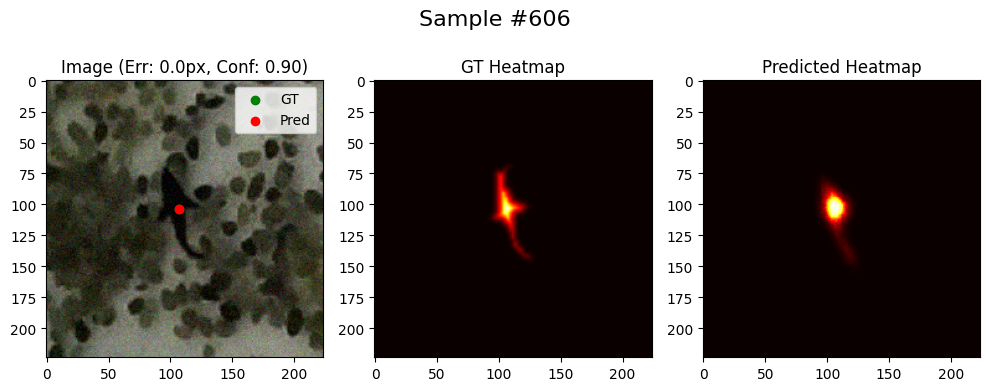

GT Value at center: 0.96, Pred Value at center: 0.89


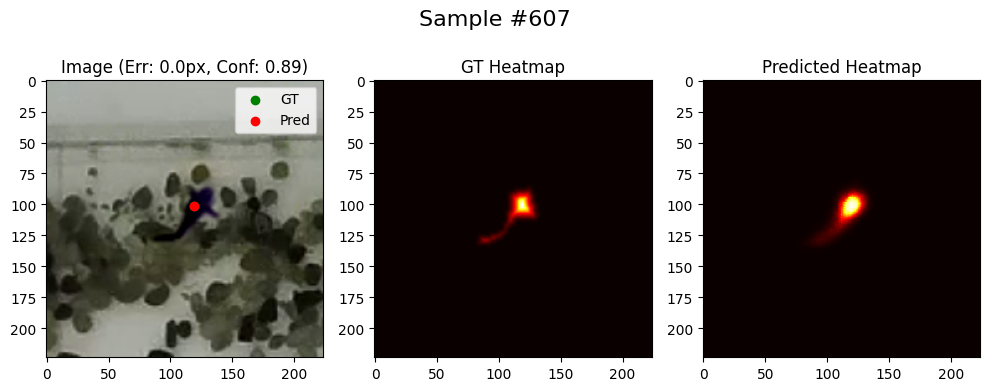

GT Value at center: 0.96, Pred Value at center: 0.91


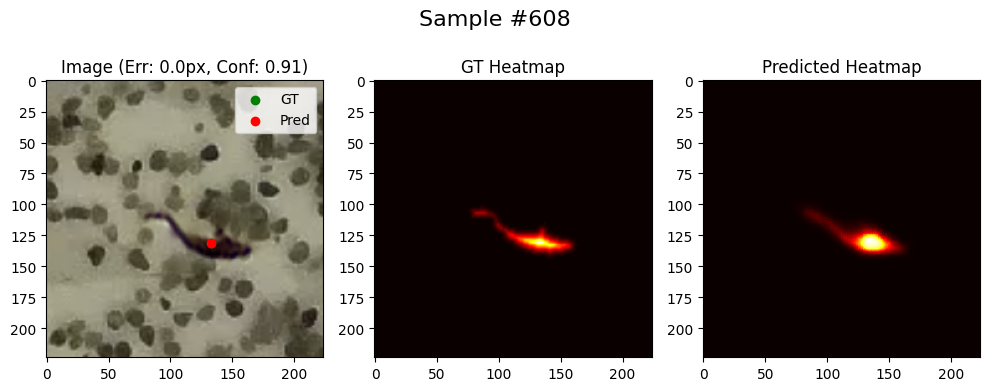

GT Value at center: 0.95, Pred Value at center: 0.85


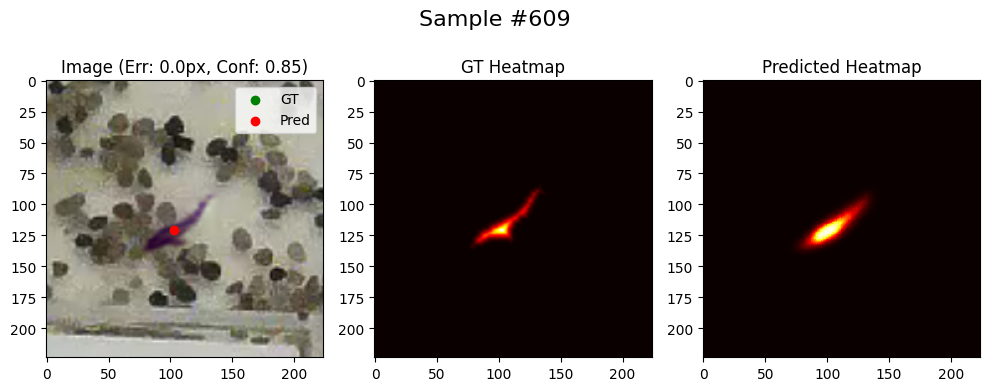

GT Value at center: 0.99, Pred Value at center: 0.93


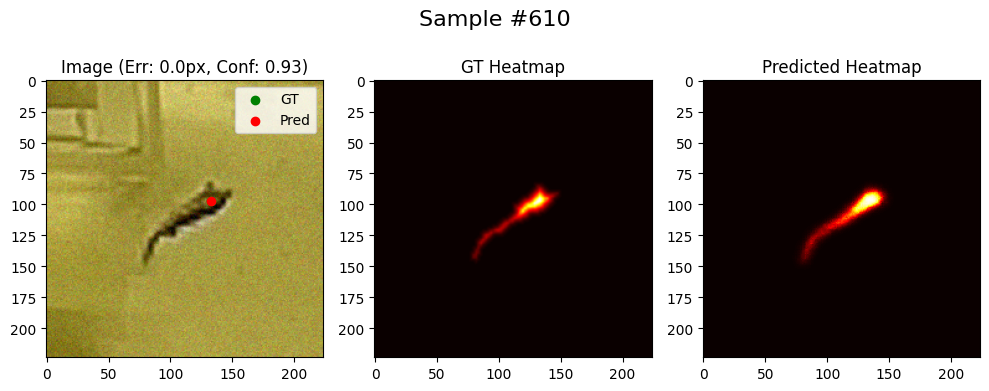

GT Value at center: 0.95, Pred Value at center: 0.90


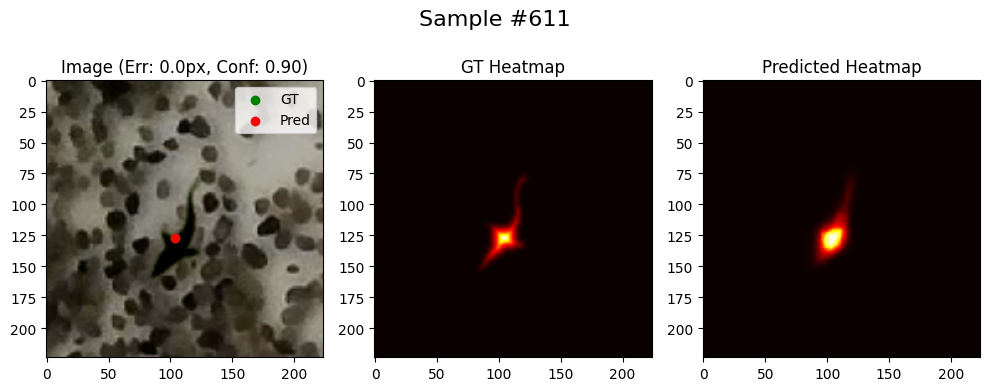

In [12]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)